## **Data Loading**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [3]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


## **Data Preprocessing**

In [4]:
import pandas as pd 
df = pd.read_csv(data_file_path, sep='\t', names=["Label", "Text"], header=None)

In [5]:
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.shape

(5572, 2)

In [7]:
df["Label"].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
def create_balanced_df(df):
    # Count of Spam
    num_spam = df[df['Label'] == "spam"].shape[0]
    # Randomly sample "ham" to match the number of "spam"
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state = 123)
    # Combine ham with spam 
    balanced_df = pd.concat([ham_subset, df[df['Label'] == 'spam']])

    return balanced_df

In [9]:
balanced_df = create_balanced_df(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [10]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [11]:
def random_split(df, train_frac, val_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop = True)

    train_end = int(len(df) * train_frac)
    val_end = train_end + int(len(df) * val_frac)

    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]

    return train_df, val_df, test_df 

In [12]:
train_df, val_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [13]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1045, 2)
(149, 2)
(300, 2)


In [14]:
# train_df.to_csv("train.csv", index=None)
# val_df.to_csv("validation.csv", index=None)
# test_df.to_csv("test.csv", index=None)

## **Dataset & DataLoaders**

In [15]:
import torch 
from torch.utils.data import Dataset, DataLoader
import tiktoken

class SMSDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length = None, pad_token = 50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize text 
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ] 

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate the sequence if they are longer than max length 
            self.encoded_texts = [
                encoded_text[:max_length] for encoded_text in self.encoded_texts
            ]
        
        # Pad sequences to the longest Sequence 
        self.encoded_texts = [
            encoded_text + [pad_token] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long), 
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0 
        for encoded_text in self.encoded_texts:
            encoded_text = len(encoded_text)
            if encoded_text > max_length:
                max_length = encoded_text
        return max_length

Step 1: Pre-tokenize texts
    
Step 2: Truncate sequences if they are longer than max_length
    
Step 3: Pad sequences to the longest sequence

In [16]:
tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SMSDataset(
    csv_file="train.csv", 
    tokenizer=tokenizer, 
    max_length=None, 
)

In [17]:
val_dataset = SMSDataset(
    csv_file="validation.csv", 
    tokenizer=tokenizer, 
    max_length = train_dataset.max_length
)

test_dataset = SMSDataset(
    csv_file="test.csv", 
    tokenizer=tokenizer,
    max_length = train_dataset.max_length
)

In [18]:
NUM_WORKERS = 0 
BATCH_SIZE = 8 
torch.manual_seed(123) 

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS, 
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    drop_last=False
)

test_loader = DataLoader(
    dataset = test_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    drop_last=False
)

In [19]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [20]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## **Model Loading**

In [40]:
import json
with open("C:\\Users\\hites\\OneDrive\\Desktop\\GPT\\GPT_Model_Configuration\\GPT_config_355M.json", "r") as f:
    GPT_CONFIG_355M = json.load(f)

In [41]:
assert train_dataset.max_length <= GPT_CONFIG_355M["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model context length"
    f"Length {GPT_CONFIG_355M['context_length']} Reinitialize data sets with"
    f"Max length = {GPT_CONFIG_355M['context_length']}"
)  

In [48]:
# Solving Importing issue with 2 level up directory path
workspace_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if workspace_root not in sys.path:
    sys.path.insert(0, workspace_root)

In [43]:
from GPT.gpt_download import download_and_load_gpt2

In [44]:

settings, params = download_and_load_gpt2(model_size="355M", models_dir="C:\\Users\\hites\\OneDrive\\Desktop\\GPT\\gpt2_355M")

c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\checkpoint


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\encoder.json


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\hparams.json


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.data-00000-of-00001


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.index


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\model.ckpt.meta


c:\Users\hites\OneDrive\Desktop\GPT\venv\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: C:\Users\hites\OneDrive\Desktop\GPT\gpt2_355M\355M\vocab.bpe


In [45]:
print(f"Model settings: {settings}")

Model settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}


In [59]:
from GPT.GPT_Model import GPTModel
from GPT.Model_Weights_Loading import load_weights_into_gpt 
from GPT.Text_Generation import generate_and_print_sample, generate_simple_text
from GPT.Tokenization import text_to_tokens ,token_to_text

In [58]:
model = GPTModel(GPT_CONFIG_355M)
load_weights_into_gpt(model, params)
model.eval();

In [62]:
text = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_simple_text(
    model=model,
    idx=text_to_tokens(text, tokenizer),
    max_new_tokens=23,
    context_size=GPT_CONFIG_355M["context_length"]
)

print(token_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Thou firsthand LU poly Stalin Doomesty engineering Boysivities fixture relegated tuningrior bailed Ish Northernigun155ummer surprismanerr


Based on the output, it's apparent that the model struggles with following instructions.

# **Finetuning**

## **Adding Classification Head and Freezing all the params**

Modifying pretrained LLM to prepare it for classification-finetuning

To do this, we replace the original output layer, which maps the hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 ("not spam") and 1 ("spam"),

In [91]:
print(model.out_head)

Linear(in_features=1024, out_features=2, bias=True)


Freezing model, Making all layers non-trainable

In [65]:
for param in model.parameters():
    param.requires_grad = False

Then, Replacing the output layer (model.out_head), which originally maps the layer inputs to 50,257 dimensions (the size of the vocabulary):

In [67]:
torch.manual_seed(123)

num_classes = 2 
model.out_head = torch.nn.Linear(in_features=GPT_CONFIG_355M["emb_dim"], out_features=num_classes)

configuring the last transformer block and the final LayerNorm module, which connects this block to the output layer, to be trainable

In [69]:
for param in model.trf_block[-1].parameters():
    param.requires_grad = True 

for param in model.final_norm.parameters():
    param.requires_grad = True

In [96]:
model.out_head

Linear(in_features=1024, out_features=2, bias=True)

In [95]:
from torchinfo import summary 
summary(model)

Layer (type:depth-idx)                        Param #
GPTModel                                      --
├─Embedding: 1-1                              (51,463,168)
├─Embedding: 1-2                              (1,048,576)
├─Dropout: 1-3                                --
├─Sequential: 1-4                             --
│    └─TransformerBlock: 2-1                  --
│    │    └─MultiHeadAttention: 3-1           (4,198,400)
│    │    └─FeedForward: 3-2                  (8,393,728)
│    │    └─LayerNorm: 3-3                    (2,048)
│    │    └─LayerNorm: 3-4                    (2,048)
│    │    └─Dropout: 3-5                      --
│    └─TransformerBlock: 2-2                  --
│    │    └─MultiHeadAttention: 3-6           (4,198,400)
│    │    └─FeedForward: 3-7                  (8,393,728)
│    │    └─LayerNorm: 3-8                    (2,048)
│    │    └─LayerNorm: 3-9                    (2,048)
│    │    └─Dropout: 3-10                     --
│    └─TransformerBlock: 2-3          

In [77]:
# Example 
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print(f"Inputs: {inputs}")
print(f"Input Dimensions: {inputs.shape}") #Shape: {batch_size, num_tokens}

Inputs: tensor([[5211,  345,  423,  640]])
Input Dimensions: torch.Size([1, 4])


In [79]:
with torch.no_grad():
    outputs = model(inputs)
print(f"Outputs:\n {outputs}")
print(f"\nOutputs Dimension: \n{outputs.shape}") #Shape: {batch_size, num_tokens, num_classes}

Outputs:
 tensor([[[ 0.0475,  0.1572],
         [-0.6567, -0.2082],
         [-0.9845, -0.2350],
         [ 0.2696, -0.3859]]])

Outputs Dimension: 
torch.Size([1, 4, 2])


earlier, a similar input would have produced an output tensor of [1, 4, 50257], where 50,257 represents the vocabulary size.

previous, the number of output rows corresponds to the number of input tokens (in this case, 4).

However, each output's embedding dimension (the number of columns) is now reduced to 2 instead of 50,257 since we replaced the output layer of the model.

- we are interested in finetuning this model so that it returns a class label that indicates whether a model input is spam or not spam.

To achieve this, we don't need to finetune all 4 output rows but can focus on a single output token.

we will focus on the last row corresponding to the last output token

In [81]:
# To extract the last output token
last_output = outputs[:, -1, :]

In [84]:
print(f"Last Output token: {last_output}")

Last Output token: tensor([[ 0.2696, -0.3859]])


## **Calculating Classification Loss and Accuracy**

In [99]:
probas = torch.softmax(last_output, dim = -1)
label = torch.argmax(probas)
print(f"Class Label: {label.item()}")

Class Label: 0


In [100]:
def calc_accuracy_loader(model, data_loader, device, num_batches = None):
    model.eval()
    correct_predictions, num_examples = 0, 0 

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :] # Logits of last token 
            predicted_labels = torch.argmax(logits, dim = -1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break 
    return correct_predictions / num_examples

In [101]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(model, train_loader, device, num_batches=10)
val_accuracy = calc_accuracy_loader(model, val_loader, device, num_batches=10)
test_accuracy = calc_accuracy_loader(model, test_loader, device, num_batches=10)

In [102]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 50.00%


Without Pre-training our Accuracy is around 50%, Lets Pre-train and improve our accuracy

In [103]:
def calc_loss_batch(model, input_batch, target_batch, device = None):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] #Logits of last output token 
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss 

We use the calc_loss_batch function to compute the loss for a single batch obtained from the previously defined data loaders. To calculate the loss for all batches in a data loader, Creating the calc_loss_loader function

In [106]:
# Same as GPT Pre-training code 
def calc_loss_loader(model, data_loader, device, num_batches = None):
    total_loss = 0. 
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reducing the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(model, input_batch, target_batch, device)
            total_loss += loss.item()
        else:
            break 
    return total_loss / num_batches

In [107]:
with torch.no_grad():
    train_loss = calc_loss_loader(model, train_loader, device, num_batches=5)
    val_loss = calc_loss_loader(model, val_loader, device, num_batches=5)
    test_loss = calc_loss_loader(model, test_loader, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.852
Validation loss: 0.779
Test loss: 0.763


# **Pre-training the model on Supervised Data**

- Step 1: Set model to training mode

- Step 2: Reset loss gradients from previous batch iteration

- Step 3: Calculate loss gradients

- Step 4: Update model weights using loss gradients

- Step 5: New: track examples instead of tokens

- Step 6: Optional evaluation step

- Step 7: Calculate accuracy after each epoch

In [111]:
import tqdm

# same code as `train_model_simple` in LLM_Pre_training
def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop 
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Put model on training 
        model.train()

        for input_batch, target_batch in train_loader:
            # Reset the loss gradients from previous batch iterations 
            optimizer.zero_grad()

            loss = calc_loss_batch(model, input_batch, target_batch, device)

            # Calculate loss gradients
            loss.backward()

            # Update model weights using loss gradients 
            optimizer.step()

            # Tracking examples instead of tokens 
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Evaluation step 
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epochs: {epoch + 1} | (Step {global_step:06d}): "
                      f"Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")
        
        # Calculate accuracy after the epoch 
        train_accuracy = calc_accuracy_loader(model = model, data_loader=train_loader, device=device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(model=model, data_loader=val_loader, device=device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
    
    return train_losses, val_losses, train_acc, val_acc, examples_seen

In [112]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(model, train_loader, device, num_batches = eval_iter)
        val_loss = calc_loss_loader(model, train_loader, device, num_batches = eval_iter)
    model.train()
    return train_loss, val_loss

initializing the optimizer, set the number of training epochs, and initiate the training using the train_classifier_simple function.

In [113]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, weight_decay=0.1)

num_epochs = 5 
train_losses, val_losses, train_accs, val_accs, example_seen = train_classifier(model = model, train_loader = train_loader, val_loader=val_loader, optimizer=optimizer, device = device, num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epochs: 1 | (Step 000000): Train Loss: 0.762, Val Loss: 0.784
Epochs: 1 | (Step 000050): Train Loss: 0.360, Val Loss: 0.331
Epochs: 1 | (Step 000100): Train Loss: 0.373, Val Loss: 0.456


 20%|██        | 1/5 [21:24<1:25:37, 1284.27s/it]

Training accuracy: 82.50% | Validation accuracy: 85.00%
Epochs: 2 | (Step 000150): Train Loss: 0.233, Val Loss: 0.380
Epochs: 2 | (Step 000200): Train Loss: 0.313, Val Loss: 0.285
Epochs: 2 | (Step 000250): Train Loss: 0.085, Val Loss: 0.313


 40%|████      | 2/5 [43:10<1:04:52, 1297.34s/it]

Training accuracy: 87.50% | Validation accuracy: 92.50%
Epochs: 3 | (Step 000300): Train Loss: 0.125, Val Loss: 0.064
Epochs: 3 | (Step 000350): Train Loss: 0.102, Val Loss: 0.138


 60%|██████    | 3/5 [1:05:37<43:59, 1319.97s/it]

Training accuracy: 95.00% | Validation accuracy: 87.50%
Epochs: 4 | (Step 000400): Train Loss: 0.030, Val Loss: 0.057
Epochs: 4 | (Step 000450): Train Loss: 0.045, Val Loss: 0.021
Epochs: 4 | (Step 000500): Train Loss: 0.003, Val Loss: 0.012


 80%|████████  | 4/5 [1:20:48<19:18, 1158.30s/it]

Training accuracy: 100.00% | Validation accuracy: 90.00%
Epochs: 5 | (Step 000550): Train Loss: 0.007, Val Loss: 0.003
Epochs: 5 | (Step 000600): Train Loss: 0.005, Val Loss: 0.017


100%|██████████| 5/5 [1:35:35<00:00, 1147.06s/it]

Training accuracy: 97.50% | Validation accuracy: 90.00%
Training completed in 95.59 minutes.


In [114]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

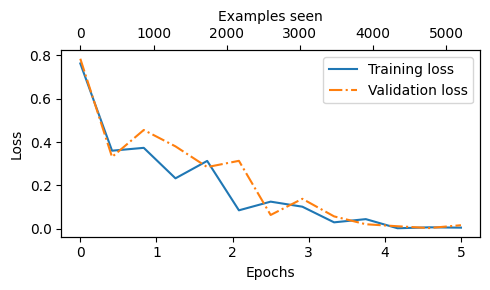

In [115]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

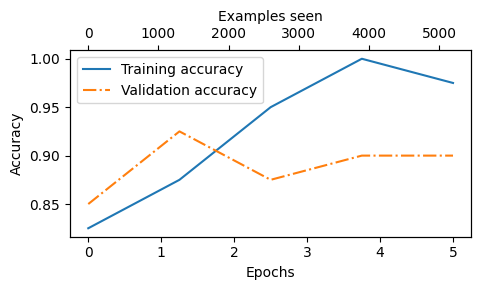

In [116]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [118]:
train_accuracy = calc_accuracy_loader(model, train_loader, device)
val_accuracy = calc_accuracy_loader(model, val_loader, device)
test_accuracy = calc_accuracy_loader(model, test_loader, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.52%
Validation accuracy: 93.29%
Test accuracy: 92.00%


## **Using LLM as a SPAM Classifier**

Step 1: Prepare inputs to the model

Step 2: Truncate sequences if they too long
    
Step 3: Pad sequences to the longest sequence

Step 4: Add batch dimension

Step 5: Model inference without gradient tracking
    
Step 6: Logits of the last output token

Step 7: Return the classified result

In [120]:
def classify_review(text, model, tokenizer, device, max_length = None, padding_token_id = 50256):
    model.eval()

    # Inputs to the model 
    input_ids = tokenizer.encode(text) 
    supported_context_length = model.pos_emb.weight.shape[0] # Emb_dim: 1024 

    # Truncate sentences if they are long 
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence 
    input_ids += [padding_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # Add Batch Dimension 

    # Model inference 
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :] #Extracting logits of last input tokens 
    predicted_label = torch.argmax(logits, dim = -1).item()

    # Return the classified input 
    return "Spam" if predicted_label == 1 else "Not Spam"

In [121]:
text_1 = (
    "You won 10000$ cash award, claim it fast by clicking the link"
)

print(classify_review(text = text_1,model = model,tokenizer = tokenizer,device = device, max_length=train_dataset.max_length))

Spam


In [122]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

Not Spam


### **Saving & Loading Trained model Weights** 

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

In [127]:
New_model = GPTModel(GPT_CONFIG_355M)
New_model.out_head = torch.nn.Linear(in_features=GPT_CONFIG_355M["emb_dim"], out_features=2)

In [128]:
model_state_dict = torch.load("review_classifier.pth")
New_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [131]:
text_1 = (
    "You won 10000$ cash award, claim it fast by clicking the link"
)

print(classify_review(text = text_1,model = New_model, tokenizer = tokenizer,device = device, max_length=train_dataset.max_length))

Spam
